In [2]:
import altair as alt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


%matplotlib inline

In [3]:
df = pd.read_csv('ecommerce_sample.csv')# .drop(['year', 'day','month','Date'], axis=1)
len(df)

20000

In [4]:
# create new variable: discount_percent

df["discount_percent"] = ((df.retail_price - df.discounted_price)*100)/df.retail_price
df.discount_percent.head()

0    62.062062
1    29.576764
2    50.050050
3    61.802575
4     4.545455
Name: discount_percent, dtype: float64

In [5]:
def get_nth_category(dataframe, level=1):
    """extract the level-n product category from the product category tree"""
    
    if level == 1:
        category = dataframe.product_category_tree.apply(lambda x: re.split(" >> ", x)[0]).str[2:]
    else:
        category = dataframe.product_category_tree.apply(lambda x: re.split(" >> ", x)[level:(level+1)])
    
    category = category.replace("[]", "[EMPTY_LEVEL]")  # this line does not work! Suggestions welcome :)

    return category

In [6]:
# print level 4 categories just to see if the function works
print(get_nth_category(df, level=4))

0                                          [Alisha Shorts]
1                                                       []
2                                                       []
3                                          [Alisha Shorts]
4        [Sicons All Purpose Arnica Dog Shampoo (500 ml...
                               ...                        
19995                                                   []
19996                                                   []
19997                                                   []
19998                                                   []
19999                                                   []
Name: product_category_tree, Length: 20000, dtype: object


In [7]:
# get primary and secondary level product categories

df["primary_category"] = get_nth_category(df, level=1)
df["secondary_category"] = get_nth_category(df, level=2)

In [8]:
print(df.primary_category.head(5), "\n\n")
print(df.secondary_category.head(5))

0        Clothing
1       Furniture
2        Footwear
3        Clothing
4    Pet Supplies
Name: primary_category, dtype: object 


0    [Lingerie, Sleep & Swimwear]
1            [Sofa Beds & Futons]
2                    [Ballerinas]
3    [Lingerie, Sleep & Swimwear]
4              [Skin & Coat Care]
Name: secondary_category, dtype: object


In [9]:
# check missing values in the product's ratings column

print("Missing value percentage", "\n\nProduct rating: ", round(df.product_rating.isnull().sum()*100/df.shape[0], 2), "%",
      "\nOverall rating: ", round(df.overall_rating.isnull().sum()*100/df.shape[0], 2), "%")

Missing value percentage 

Product rating:  0.0 % 
Overall rating:  0.0 %


In [10]:
# groupby using primary_category

groupby_df = pd.DataFrame(df.groupby("primary_category").agg({
    "discount_percent": [np.mean],
    "primary_category": ["count"]
}))

groupby_df.columns = ["_".join(col) for col in groupby_df.columns]
groupby_df = groupby_df.sort_values(by = ["primary_category_count"], ascending=False)
groupby_df = groupby_df[groupby_df.primary_category_count > 80]

In [11]:
groupby_df

,discount_percent_mean,primary_category_count
primary_category,,
Clothing,45.070525,6198
Jewellery,40.889934,3531
Footwear,36.268531,1227
Mobiles & Accessories,50.994470,1099
Automotive,54.650991,1012
Home Decor & Festive Needs,36.649404,929
Beauty and Personal Care,19.829674,710
Home Furnishing,37.218050,700
Kitchen & Dining,43.771695,647


In [12]:
# reset index to flatten column names as output by the groupby object

groupby_df.reset_index(inplace=True)

In [13]:
print(groupby_df.head())
print(groupby_df.info())
print(groupby_df.describe())

        primary_category  discount_percent_mean  primary_category_count
0               Clothing              45.070525                    6198
1              Jewellery              40.889934                    3531
2               Footwear              36.268531                    1227
3  Mobiles & Accessories              50.994470                    1099
4             Automotive              54.650991                    1012
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   primary_category        20 non-null     object 
 1   discount_percent_mean   20 non-null     float64
 2   primary_category_count  20 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 608.0+ bytes
None
       discount_percent_mean  primary_category_count
count              20.000000               20.000000
mean               34.6

Text(0, 0.5, 'Product Category')

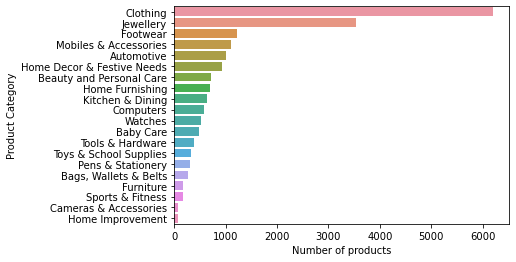

In [14]:
# product category vs product count

sns.barplot(data=groupby_df.sort_values(["primary_category_count"], ascending=False),
            y="primary_category", x = "primary_category_count")
plt.xlabel("Number of products")
plt.ylabel("Product Category")

Text(0, 0.5, 'Product Category')

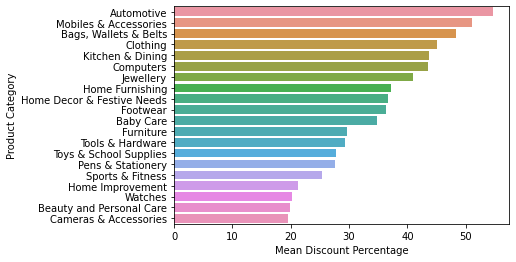

In [15]:
# product category vs category discounts

sns.barplot(data=groupby_df.sort_values(by = ["discount_percent_mean"], ascending=False),
            y="primary_category", x = "discount_percent_mean")
plt.xlabel("Mean Discount Percentage")
plt.ylabel("Product Category")

In [16]:
def is_top_category(x):
    """return 1 if x is one of the top categories"""
    if x in list(groupby_df.primary_category):
        return 1
    else:
        return 0
    
df["is_top_category"] = df.primary_category.apply(is_top_category)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Clothing'),
  Text(1, 0, 'Furniture'),
  Text(2, 0, 'Footwear'),
  Text(3, 0, 'Pens & Stationery'),
  Text(4, 0, 'Sports & Fitness'),
  Text(5, 0, 'Beauty and Personal Care'),
  Text(6, 0, 'Bags, Wallets & Belts'),
  Text(7, 0, 'Home Decor & Festive Needs'),
  Text(8, 0, 'Automotive'),
  Text(9, 0, 'Tools & Hardware'),
  Text(10, 0, 'Home Furnishing'),
  Text(11, 0, 'Baby Care'),
  Text(12, 0, 'Mobiles & Accessories'),
  Text(13, 0, 'Watches'),
  Text(14, 0, 'Toys & School Supplies'),
  Text(15, 0, 'Jewellery'),
  Text(16, 0, 'Kitchen & Dining'),
  Text(17, 0, 'Computers'),
  Text(18, 0, 'Cameras & Accessories'),
  Text(19, 0, 'Home Improvement')])

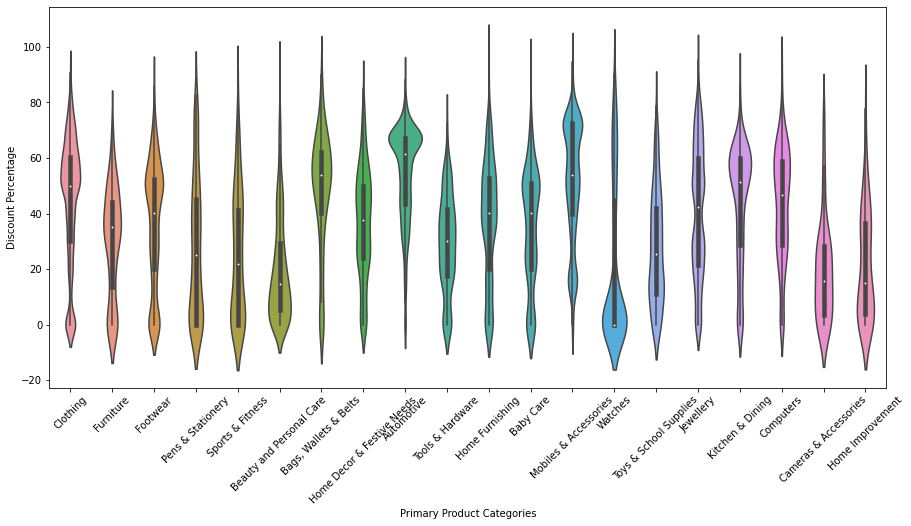

In [17]:
# subset df such that it only contains top 20 occurring categories
top_categories = df[df.is_top_category == 1]

plt.figure(figsize = [15,7])
sns.violinplot(data=top_categories, x = "primary_category", y = "discount_percent")
plt.ylabel("Discount Percentage")
plt.xlabel("Primary Product Categories")
plt.xticks(rotation=45)

# Work Below

In [33]:

source = df.head(500)

chart = alt.layer(
    data=source
)

chart

alt.LayerChart(...)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [29]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,discount_percent,primary_category,secondary_category,is_top_category
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",62.062062,Clothing,"[Lingerie, Sleep & Swimwear]",1
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",29.576764,Furniture,[Sofa Beds & Futons],1
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""...",50.050050,Footwear,[Ballerinas],1
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",61.802575,Clothing,"[Lingerie, Sleep & Swimwear]",1
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",4.545455,Pet Supplies,[Skin & Coat Care],0


In [26]:
discount = df["retail_price"] - df["discounted_price"]
print(discount)

0         620.0
1        9511.0
2         500.0
3         432.0
4          10.0
          ...  
19995     770.0
19996     286.0
19997     300.0
19998     300.0
19999     500.0
Length: 20000, dtype: float64


I think that the way I should do the plot would be by
- picking 5 different products
- finding their retail price and discount price and displaying the range